**Install the kaggle library**

In [ ]:
!pip install -q kaggle

Download dataset from Kaggle using Kaggle API

In [1]:
!kaggle datasets download -d alistairking/recyclable-and-household-waste-classification

Dataset URL: https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification
License(s): MIT
100% 920M/920M [00:12<00:00, 73.8MB/s]
100% 920M/920M [00:12<00:00, 76.2MB/s]


Unzip the dataset

In [2]:
!unzip -q recyclable-and-household-waste-classification.zip

# Import

In [3]:
from torch.utils.data import Dataset
import os
from PIL import Image
from torchvision import transforms
from torch.nn import Module
import torch.nn as nn
import torch
from torch.utils.data import random_split
import os
from torchvision import models
import torch.optim as optim
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import tqdm

Define parameters

In [4]:
num_class = 30
batch_size = 64
mode = 3 # default and real word

Create a custom class to manipulate the dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_folder, mode, num_class):
        self.root_folder = root_folder
        self.num_class = num_class
        self.list_of_classes = self.getListOfClasses()
        self.mode = mode # 1 for default 2 for real_world 3 for both
        # Set the count_per_category based on the mode
        if self.mode == 1 or self.mode == 2:
            self.count_per_category = 250
        else:
            self.count_per_category = 500
        self.category_map = self.getCategoryMap()
        self.category_wise_image_paths = self.getCategoryWiseImagePaths()
        self.printSummary()

    def printSummary(self):
        # Print a summary of the dataset
        print(f'num_class: {self.num_class}')
        print(f'list of classes: {self.list_of_classes}')
        print(f'length: {self.count_per_category * self.num_class}')

    def getCategoryWiseImagePaths(self):
        category_wise_image_paths = {}
        for folder_name in self.list_of_classes:
            image_names = []
            # If mode is 1 or 3, get image paths from the 'default' folder
            if self.mode == 1 or self.mode == 3:
                default_folder_path = os.path.join(self.root_folder, folder_name, 'default')
                files = [os.path.join('default', f) for f in os.listdir(default_folder_path) if os.path.isfile(os.path.join(default_folder_path, f))]
                image_names.extend(files)
            # If mode is 2 or 3, get image paths from the 'real_world' folder
            if self.mode == 2 or self.mode == 3:
                real_folder_path = os.path.join(self.root_folder, folder_name, 'real_world')
                files = [os.path.join('real_world', f) for f in os.listdir(real_folder_path) if os.path.isfile(os.path.join(real_folder_path, f))]
                image_names.extend(files)
            category_wise_image_paths[self.category_map[folder_name]] = image_names
        return category_wise_image_paths


    def getListOfClasses(self):
        # Get a list of classes (folder names) in the root folder
        files = [f for f in os.listdir(self.root_folder) if os.listdir(os.path.join(self.root_folder, f))]
        files = sorted(files)
        files = files[:num_class]
        return files

    def getCategoryMap(self):
        # Create a mapping of category names to category indices
        category_map = {}
        i = 0
        for category in self.list_of_classes:
            category_map[category] = i
            i += 1
        return category_map

    def __len__(self):
        # Return the total number of images in the dataset
        return self.count_per_category * self.num_class

    def __getitem__(self, index):
        # Get the category index and image number based on the given index
        category_index = index // self.count_per_category
        image_number = index % self.count_per_category
        # Get the image path based on the category index and image number
        image_path = self.category_wise_image_paths[category_index][image_number]
        full_image_path = os.path.join(self.root_folder, self.list_of_classes[category_index], image_path)
        # Apply transformations to the image and return it along with the category index

        img = Image.open(full_image_path)
        if self.transform:
            img = self.transform(img)
        return img, category_index

Specify the name of the folder where the images are saved

In [6]:
folder_path = './images/images'

Rename the classes in the folders based on categories

In [7]:
import os

# Define the categories
categories = {
    "recycling": [
        "aluminum_food_cans",
        "aluminum_soda_cans",
        "cardboard_boxes",
        "cardboard_packaging",
        "glass_beverage_bottles",
        "glass_cosmetic_containers",
        "glass_food_jars",
        "magazines",
        "newspaper",
        "office_paper",
        "paper_cups",
        "plastic_cup_lids",
        "plastic_detergent_bottles",
        "plastic_food_containers",
        "plastic_soda_bottles",
        "plastic_water_bottles",
        "steel_food_cans",
        "plastic_shopping_bags"
    ],
    "organic": [
        "eggshells",
        "food_waste",
        "coffee_grounds",
        "tea_bags"
    ],
    "garbage": [
        "disposable_plastic_cutlery",
        "aerosol_cans",
        "clothing",
        "plastic_straws",
        "plastic_trash_bags",
        "shoes",
        "styrofoam_cups",
        "styrofoam_food_containers"
    ]
}

In [9]:
# Define transformations for training and testing sets
train_transform = transforms.Compose([
    transforms.Resize((196, 196)),  # Resize the image to (196, 196) pixels
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((180, 180), padding=8),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly changes the brightness, contrast, saturation, and hue of an image by up to 20%.
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),  # Apply Gaussian blur with kernel size (7, 13) and sigma (0.1, 0.2) to reduce noises and smooth out details
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using mean and standard deviation
])

test_transform = transforms.Compose([
    transforms.Resize((196, 196)),  # Resize the image to (196, 196) pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image using mean and standard deviation
])

In [8]:
# # Iterate over the categories
for category, items in categories.items():
    # Iterate over the items in each category
    for item in items:
        # Define the old and new folder names
        old_folder = os.path.join(folder_path, item)
        new_folder = os.path.join(folder_path, f"{item}_{category}")

        # Rename the folder
        os.rename(old_folder, new_folder)

Create a train and test loader

In [10]:
training_data = CustomDataset(folder_path, mode, num_class)

num_class: 30
list of classes: ['aerosol_cans_garbage', 'aluminum_food_cans_recycling', 'aluminum_soda_cans_recycling', 'cardboard_boxes_recycling', 'cardboard_packaging_recycling', 'clothing_garbage', 'coffee_grounds_organic', 'disposable_plastic_cutlery_garbage', 'eggshells_organic', 'food_waste_organic', 'glass_beverage_bottles_recycling', 'glass_cosmetic_containers_recycling', 'glass_food_jars_recycling', 'magazines_recycling', 'newspaper_recycling', 'office_paper_recycling', 'paper_cups_recycling', 'plastic_cup_lids_recycling', 'plastic_detergent_bottles_recycling', 'plastic_food_containers_recycling', 'plastic_shopping_bags_recycling', 'plastic_soda_bottles_recycling', 'plastic_straws_garbage', 'plastic_trash_bags_garbage', 'plastic_water_bottles_recycling', 'shoes_garbage', 'steel_food_cans_recycling', 'styrofoam_cups_garbage', 'styrofoam_food_containers_garbage', 'tea_bags_organic']
length: 15000


In [11]:
# Print the index to label mapping
training_data.category_map.items()

dict_items([('aerosol_cans_garbage', 0), ('aluminum_food_cans_recycling', 1), ('aluminum_soda_cans_recycling', 2), ('cardboard_boxes_recycling', 3), ('cardboard_packaging_recycling', 4), ('clothing_garbage', 5), ('coffee_grounds_organic', 6), ('disposable_plastic_cutlery_garbage', 7), ('eggshells_organic', 8), ('food_waste_organic', 9), ('glass_beverage_bottles_recycling', 10), ('glass_cosmetic_containers_recycling', 11), ('glass_food_jars_recycling', 12), ('magazines_recycling', 13), ('newspaper_recycling', 14), ('office_paper_recycling', 15), ('paper_cups_recycling', 16), ('plastic_cup_lids_recycling', 17), ('plastic_detergent_bottles_recycling', 18), ('plastic_food_containers_recycling', 19), ('plastic_shopping_bags_recycling', 20), ('plastic_soda_bottles_recycling', 21), ('plastic_straws_garbage', 22), ('plastic_trash_bags_garbage', 23), ('plastic_water_bottles_recycling', 24), ('shoes_garbage', 25), ('steel_food_cans_recycling', 26), ('styrofoam_cups_garbage', 27), ('styrofoam_foo

In [12]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(training_data))
test_size = len(training_data) - train_size
train_dataset, test_dataset = random_split(training_data, [train_size, test_size])

In [13]:
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

In [14]:
# Create train and test loaders
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Print the classes and image shapes
image, category_index = training_data[1]
print(training_data.list_of_classes)
print(image.shape, training_data.list_of_classes[category_index])

['aerosol_cans_garbage', 'aluminum_food_cans_recycling', 'aluminum_soda_cans_recycling', 'cardboard_boxes_recycling', 'cardboard_packaging_recycling', 'clothing_garbage', 'coffee_grounds_organic', 'disposable_plastic_cutlery_garbage', 'eggshells_organic', 'food_waste_organic', 'glass_beverage_bottles_recycling', 'glass_cosmetic_containers_recycling', 'glass_food_jars_recycling', 'magazines_recycling', 'newspaper_recycling', 'office_paper_recycling', 'paper_cups_recycling', 'plastic_cup_lids_recycling', 'plastic_detergent_bottles_recycling', 'plastic_food_containers_recycling', 'plastic_shopping_bags_recycling', 'plastic_soda_bottles_recycling', 'plastic_straws_garbage', 'plastic_trash_bags_garbage', 'plastic_water_bottles_recycling', 'shoes_garbage', 'steel_food_cans_recycling', 'styrofoam_cups_garbage', 'styrofoam_food_containers_garbage', 'tea_bags_organic']
torch.Size([3, 196, 196]) aerosol_cans_garbage


Display an image from the dataset

torch.Size([3, 196, 196]) tensor(12)


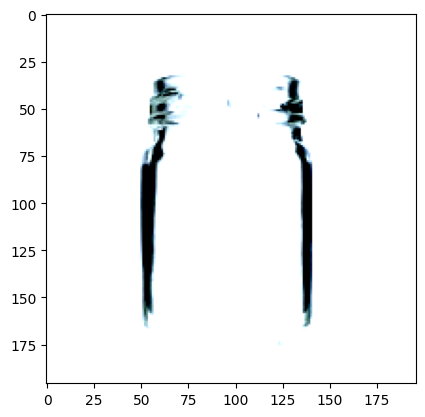

In [ ]:
images, labels = next(iter(train_dl))
print(images[0].shape, labels[0])
plt.imshow(images[0].permute(1,2,0))
plt.show()

Create a class that defines the ResNet model

In [16]:
class CustomResNet(Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet34(pretrained=True)
        num_ftrs = resnet.fc.in_features
        resnet.fc = nn.Linear(num_ftrs, num_class)
        self.model = resnet

    def forward(self, image):
        x = self.model(image)
        return x

Instantiate the ResNet model. Define the loss and optimizer.

In [17]:
model = CustomResNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = model.to(device)
print(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 109MB/s]


cuda:0


# Training

In [18]:
num_epochs = 8 # Editable
dl = train_dl
dataset_size = len(dl)
print(dataset_size)

188


In [19]:
# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Started epoch {epoch + 1}')
    running_loss = 0.0
    running_corrects = 0
    model.train()

    # Create a progress bar
    progress_bar = tqdm.tqdm(enumerate(train_dl), total=len(train_dl))

    for i, (inputs, labels) in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        corrects = torch.sum(preds == labels.data)
        running_corrects += corrects
        running_loss += loss.item() * inputs.size(0)

        # Update the progress bar
        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}')
        progress_bar.set_postfix(loss=running_loss / ((i + 1) * batch_size), acc=running_corrects.double() / ((i + 1) * batch_size))

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Evaluate the model on the test set
    model.eval()
    test_running_loss = 0.0
    test_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)
            test_running_corrects += torch.sum(preds == labels.data)
            test_running_loss += loss.item() * inputs.size(0)

    test_epoch_loss = test_running_loss / len(test_dataset)
    test_epoch_acc = test_running_corrects.double() / len(test_dataset)
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_epoch_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.4f}')

print('Training complete')

Started epoch 1


Epoch 1/8: 100%|██████████| 188/188 [01:05<00:00,  2.88it/s, acc=tensor(0.5214, device='cuda:0', dtype=torch.float64), loss=1.91]


Epoch 1/8, Loss: 1.9156, Accuracy: 0.5228, Test Loss: 0.9373, Test Accuracy: 0.7383
Started epoch 2


Epoch 2/8: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s, acc=tensor(0.7926, device='cuda:0', dtype=torch.float64), loss=0.734]


Epoch 2/8, Loss: 0.7355, Accuracy: 0.7947, Test Loss: 0.6329, Test Accuracy: 0.8040
Started epoch 3


Epoch 3/8: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s, acc=tensor(0.8573, device='cuda:0', dtype=torch.float64), loss=0.476]


Epoch 3/8, Loss: 0.4777, Accuracy: 0.8596, Test Loss: 0.5053, Test Accuracy: 0.8410
Started epoch 4


Epoch 4/8: 100%|██████████| 188/188 [01:05<00:00,  2.89it/s, acc=tensor(0.9020, device='cuda:0', dtype=torch.float64), loss=0.33]


Epoch 4/8, Loss: 0.3308, Accuracy: 0.9044, Test Loss: 0.4610, Test Accuracy: 0.8507
Started epoch 5


Epoch 5/8: 100%|██████████| 188/188 [01:05<00:00,  2.88it/s, acc=tensor(0.9272, device='cuda:0', dtype=torch.float64), loss=0.241]


Epoch 5/8, Loss: 0.2416, Accuracy: 0.9297, Test Loss: 0.4363, Test Accuracy: 0.8587
Started epoch 6


Epoch 6/8: 100%|██████████| 188/188 [01:05<00:00,  2.88it/s, acc=tensor(0.9462, device='cuda:0', dtype=torch.float64), loss=0.18]


Epoch 6/8, Loss: 0.1804, Accuracy: 0.9487, Test Loss: 0.4274, Test Accuracy: 0.8523
Started epoch 7


Epoch 7/8: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s, acc=tensor(0.9560, device='cuda:0', dtype=torch.float64), loss=0.143]


Epoch 7/8, Loss: 0.1430, Accuracy: 0.9586, Test Loss: 0.4258, Test Accuracy: 0.8567
Started epoch 8


Epoch 8/8: 100%|██████████| 188/188 [01:05<00:00,  2.87it/s, acc=tensor(0.9624, device='cuda:0', dtype=torch.float64), loss=0.115]


Epoch 8/8, Loss: 0.1151, Accuracy: 0.9650, Test Loss: 0.4270, Test Accuracy: 0.8563
Training complete


Plotting the accuracy and loss

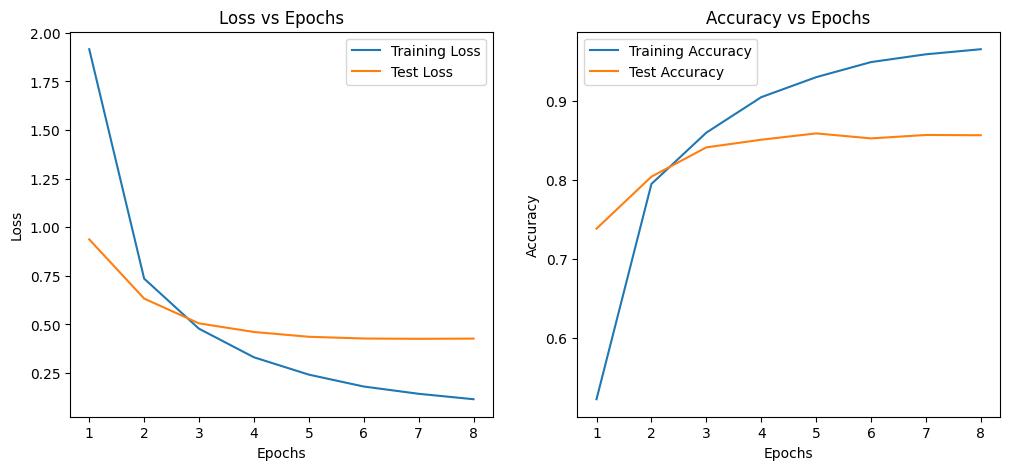

In [ ]:
# Plotting loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()

Save the model

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Inference
Load the test images in the inference-images folder

Load the model

In [20]:
model = CustomResNet()
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

CustomResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

Create a dataset for the inference images

In [21]:
class InferenceDataset(Dataset):
    def __init__(self, root_folder):
        self.root_folder = root_folder
        self.image_paths = os.listdir(self.root_folder)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        full_image_path = os.path.join(self.root_folder, image_path)
        img = self.doTransform(full_image_path)
        return img, image_path  # return image and image path

    def doTransform(self, image_path):
      img = Image.open(image_path).convert('RGB')  # Convert image to RGB
      transform = transforms.Compose([
          transforms.Resize((196,196)),
          transforms.ToTensor(),
          transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
      img = transform(img)
      return img

In [22]:
# Create a dataset for the inference images
inference_data = InferenceDataset('./inference-images')
inference_dl = DataLoader(inference_data, batch_size, shuffle=False)

Make predictions

Predicted classes: ['cardboard_boxes_recycling', 'shoes_garbage', 'clothing_garbage', 'eggshells_organic']


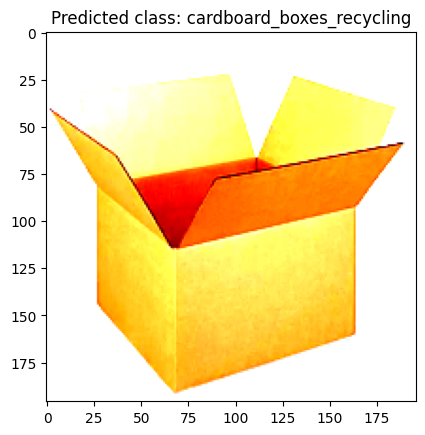

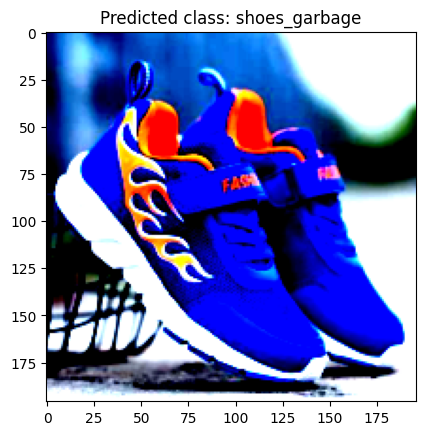

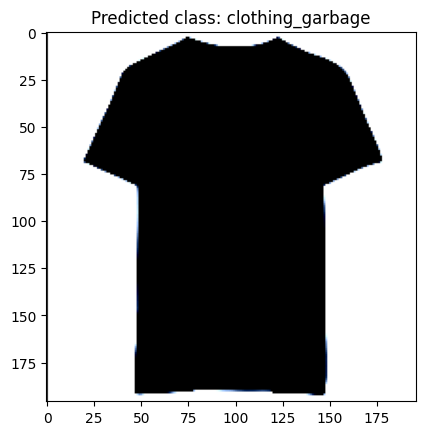

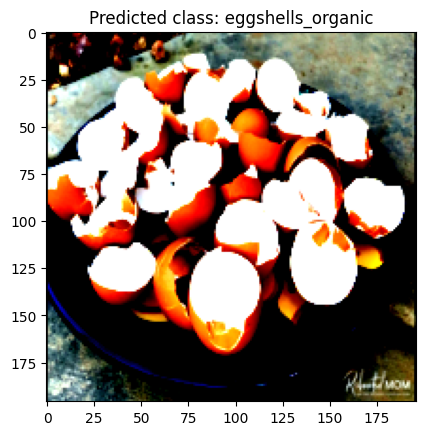

In [23]:
# Create a reverse mapping from indices to class names
index_to_class = {v: k for k, v in training_data.category_map.items()}

# Make inferences
for inputs, image_paths in inference_dl:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # Get the predicted labels
    predicted_labels = [index_to_class[idx.item()] for idx in preds]
    print(f'Predicted classes: {predicted_labels}')

    # Display the images along with their predicted labels
    for i in range(inputs.shape[0]):
        plt.imshow(inputs[i].cpu().permute(1,2,0))  # Move tensor to CPU
        plt.title(f'Predicted class: {predicted_labels[i]}')
        plt.show()
